# Plotting Fire Data on a Bubble Map 

## Using Plotly for Python 

[Plotly](https://plot.ly/#/) has a [Python library](https://plot.ly/python/) that allows you to create interactive data visualizations online, such as line plots, scatter maps, heatmaps, and 3D network graphs. In this tutorial, we will create a bubble map that visualizes wildfire data in California (based on the FIRMS data we acquired). 

Follow the [Getting Started](https://plot.ly/python/getting-started/) tutorial to set up the Plotly.py library. Once that is done, let's import some libraries that we will use in this tutorial:

In [2]:
import plotly.plotly as py
#import pandas as pd
from datascience import *
import numpy as np

Our FIRMS dataset is quite big, so let's narrow it down to just a few points on the map. I'd like to plot the 4 brightest, 4 most "mediocre"ly bright, and 4 dimmest wildfires in the dataset. 

First, let's load the .csv file into a table:

In [2]:
data=Table().read_table('~/URAP/google_earth_fires/data/SoCal_fires.csv') #from https://github.com/jupyterhub/jupyterhub/issues/376
data

latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,type
36.234,-118.43,321.9,1,1,2017-10-07,1845,Terra,MODIS,44,6.1,302.5,14.5,0
36.258,-118.421,319.4,4.7,2,2017-10-15,1756,Terra,MODIS,72,6.1,294.9,138.7,0
36.259,-118.425,318.2,4.7,2,2017-10-15,1756,Terra,MODIS,44,6.1,294.4,118.3,0
36.256,-118.42,345.1,1.1,1,2017-10-15,2112,Aqua,MODIS,92,6.1,298.3,50,0
36.272,-118.429,326.3,1.1,1,2017-10-16,1839,Terra,MODIS,71,6.1,293,23.1,0
36.271,-118.418,331.1,1.1,1,2017-10-16,1839,Terra,MODIS,83,6.1,292.7,29.9,0
36.255,-118.412,300,3,1.6,2017-10-16,913,Aqua,MODIS,5,6.1,281.5,31.6,0
36.256,-118.428,327,4,1.9,2017-10-16,2017,Aqua,MODIS,77,6.1,278.8,192.8,0
36.253,-118.428,330.3,1.4,1.2,2017-10-17,542,Terra,MODIS,100,6.1,281.1,49.7,0
36.412,-119.232,339.2,1.7,1.3,2017-09-08,1916,Terra,MODIS,87,6.1,302.5,73.2,0


## Filtering the data

Now, let's select our columns of interest. For the purposes of this tutorial, we care about the latitude, longitude, brightness, and dates of our data.

In [3]:
py_data=data.select(0,1,2,5) #get the columns you want
py_data

latitude,longitude,brightness,acq_date
36.234,-118.43,321.9,2017-10-07
36.258,-118.421,319.4,2017-10-15
36.259,-118.425,318.2,2017-10-15
36.256,-118.42,345.1,2017-10-15
36.272,-118.429,326.3,2017-10-16
36.271,-118.418,331.1,2017-10-16
36.255,-118.412,300,2017-10-16
36.256,-118.428,327,2017-10-16
36.253,-118.428,330.3,2017-10-17
36.412,-119.232,339.2,2017-09-08


Next, let's find the top 5 brightest fires in our data. To do this, we can sort the brightness from brightest to dimmest, and use the numpy.take method to grab the first 5 rows. You will also do the same thing to find the 5 dimmest fires, except you will sort from dimmest to brightest.

In [4]:
brightest=py_data.sort('brightness', descending=True).take(range(0,5))
brightest

latitude,longitude,brightness,acq_date
34.466,-119.078,504,2017-12-06
34.47,-119.652,503.7,2017-12-16
34.549,-119.35,502.4,2017-12-11
34.415,-119.41,502.3,2017-12-10
34.477,-119.079,501.9,2017-12-06


In [5]:
dimmest=py_data.sort('brightness',descending=False).take(range(0,5))
dimmest

latitude,longitude,brightness,acq_date
36.255,-118.412,300,2017-10-16
34.339,-118.32,300,2017-12-06
37.681,-119.592,300,2017-10-08
37.212,-119.418,300,2017-12-06
36.693,-119.7,300,2018-01-26


Finding the middle 5 fires will take a bit more work. First, we will find the median of our brightness values. Then, we will find the index of table in which the median is located. Finally, we will want to take the two rows above the median and the two rows below the median to get the middle 5 of the table. 

In [6]:
bright_col=py_data.sort('brightness',descending=False).column('brightness') #the brightness column of our data
medium=np.median(bright_col) #find median of brightnesses
list(bright_col).index(medium) #find index of median


3017

In [7]:
middle=py_data.take(range((3017-2),(3017+3))) #take two above and two below median to get "middle 5 brightest"
middle

latitude,longitude,brightness,acq_date
34.456,-119.371,300.1,2017-12-09
34.478,-119.409,311.4,2017-12-09
34.476,-119.421,313.2,2017-12-09
34.474,-119.431,313.6,2017-12-09
34.436,-119.351,367.4,2017-12-09


Now, it's time to concatenate all our data! I am going to create arrays for each variable that we are interested in, using data from our "brightest", "middle", and "dimmest" tables.

In [8]:
lats=np.append(np.append(brightest.column(0),(middle.column(0))), dimmest.column(0))
longs=np.append(np.append(brightest.column(1),(middle.column(1))), dimmest.column(1))
brights=np.append(np.append(brightest.column(2),(middle.column(2))), dimmest.column(2))
dates=np.append(np.append(brightest.column(3),(middle.column(3))), dimmest.column(3))

Now, let's create a new table with columns for these variables! This table will contain the latitude, longitude, brightness, and dates of the top 5 brightest, middle 5, and 5 dimmest fire data. 

In [9]:
filtered_data=Table().with_columns(
        'latitude', lats,
        'longitude', longs,
        'brightness', brights,
        'acq_date', dates
        )
filtered_data

latitude,longitude,brightness,acq_date
34.466,-119.078,504,2017-12-06
34.47,-119.652,503.7,2017-12-16
34.549,-119.35,502.4,2017-12-11
34.415,-119.41,502.3,2017-12-10
34.477,-119.079,501.9,2017-12-06
34.456,-119.371,300.1,2017-12-09
34.478,-119.409,311.4,2017-12-09
34.476,-119.421,313.2,2017-12-09
34.474,-119.431,313.6,2017-12-09
34.436,-119.351,367.4,2017-12-09


## Plotting the data

Here's where things get a bit tricky. Ultimately, we would like to plot a figure with a specific set of data and a specific layout. Plotly has many attributes to help us accomplish our goal, but how do we know which ones to use? Luckily, Plotly has a [figure reference!](https://plot.ly/python/reference/)

Let's initialize our data first. We want to have different-colored bubbles on our bubble map so that we can differentiate between the three levels of brightness. Let's create a list of colors to choose from, using their RGB values: 

In [10]:
colors = ["rgb(255,0,0)", "rgb(255,128,0)", "rgb(255,255,0)"] #red, orange, yellow

Next, we'll create a list called limits. Limits contains three elements, and each element contains the beginning index and ending index of a brightness level. This list will allow us to map certain attributes to a specific range of data. For example, if we assign the first element of [colors] to the first element in [limits], the 5 brightest fires will appear as red bubbles on the map.

In [11]:
limits=[(0,5),(5,10),(10,15)] #we are grouping by brightness, where first five (0,5) are brightest, second group of five (5,10) are medium, etc.

Now, it's time to create a list that contains all the information that we want to represent on the map. We'll call this list "fires." In the end, we want this list to hold three dictionaries (one for each brightness level). 

Since we have three brightness levels, we want to assign specific attributes to each of them. To do this, we will iterature through each of the groups and create a dictionary of attributes for each. If you are unclear about these attributes, refer to the [figure reference!](https://plot.ly/python/reference/).

In [12]:

#colors = ["rgb(255,0,0)", "rgb(255,128,0)", "rgb(255,255,0)"] #red, orange, yellow
#limits=[(0,5),(5,10),(10,15)] #we are grouping by brightness, where first five (0,5) are brightest, second group of five (5,10) are medium, etc.

fires=[] #the data that we want to represent on the map
for i in range(len(limits)): #we want to iterate 3 times to create 3 traces on the map 
    group=filtered_data.take(range(limits[i][0], limits[i][1])) #i.e: in the first iteration, we are taking the top 5 rows (the brightest) 
    fire=dict(
        type = 'scattergeo', #the type of figure we want to create 
        locationmode = 'USA-states', 
        lon = group['longitude'],
        lat = group['latitude'],
        location=['California'], #this doesn't do anything
        #text = three_sub['text'],
        marker=dict(
                size=group['brightness'].item(0)/20, #scale the size of the bubble; our bubble size is based on the brightness 
                color=colors[i], #the color of the bubbles in this group 
                line = dict(width=0.5, color='rgb(40,40,40)'), 
                sizemode='diameter'
                ), #sets the properties of the bubbles 
        name='{0}-{1}'.format(limits[i][0], limits[i][1])) #legend labels
    fires.append(fire)

Let's see what our "fires" dictionary looks like: 

In [13]:
fires

[{'lat': array([34.466, 34.47 , 34.549, 34.415, 34.477]),
  'location': ['California'],
  'locationmode': 'USA-states',
  'lon': array([-119.078, -119.652, -119.35 , -119.41 , -119.079]),
  'marker': {'color': 'rgb(255,0,0)',
   'line': {'color': 'rgb(40,40,40)', 'width': 0.5},
   'size': 25.2,
   'sizemode': 'diameter'},
  'name': '0-5',
  'type': 'scattergeo'},
 {'lat': array([34.456, 34.478, 34.476, 34.474, 34.436]),
  'location': ['California'],
  'locationmode': 'USA-states',
  'lon': array([-119.371, -119.409, -119.421, -119.431, -119.351]),
  'marker': {'color': 'rgb(255,128,0)',
   'line': {'color': 'rgb(40,40,40)', 'width': 0.5},
   'size': 15.005,
   'sizemode': 'diameter'},
  'name': '5-10',
  'type': 'scattergeo'},
 {'lat': array([36.255, 34.339, 37.681, 37.212, 36.693]),
  'location': ['California'],
  'locationmode': 'USA-states',
  'lon': array([-118.412, -118.32 , -119.592, -119.418, -119.7  ]),
  'marker': {'color': 'rgb(255,255,0)',
   'line': {'color': 'rgb(40,40,40)

Next, we will dictate what our figure layout should be. 

In [14]:
layout=dict(
        title='Range of Wildfire Brightnesses in California from 09/01/2017 to 09/01/2018',
        showlegend=True,
        geo = dict(
            scope='CA', #doesn't do anything??
            projection=dict( type='albers usa'), #provides the gray USA map 
            center=dict(lon=-116.4194, lat=34.9592), #centers the map on the middle of SoCal when you first create the map
            zoom=6, #Zoom factor of map when you create it 
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires, layout=layout) #our figure with fires data and the layout we want 
py.iplot(fig, validate=False, filename='SoCal-FIRMS-bubble-map') #plot the data! 

In [15]:
dimmest['latitude']

array([36.255, 34.339, 37.681, 37.212, 36.693])

In [16]:
dimmest.take(0)['latitude'].item(0)

36.255

### Resources

-  [basemap](https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html)
-  [basemap legends](https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html)
-  [i4 channel details](https://viirsland.gsfc.nasa.gov/PDF/VIIRS_activefire_375m_ATBD.pdf)
-  [ah](https://help.plot.ly/excel/bubble-maps/)

## Add more data points! 
Here, I am just doing the same steps but getting a total of 300 data points in the end and tweaking the map.

In [88]:
brightest100=py_data.sort('brightness', descending=True).take(range(0,100))
brightest100

latitude,longitude,brightness,acq_date
34.466,-119.078,504,2017-12-06
34.47,-119.652,503.7,2017-12-16
34.549,-119.35,502.4,2017-12-11
34.415,-119.41,502.3,2017-12-10
34.477,-119.079,501.9,2017-12-06
34.474,-119.096,501.5,2017-12-06
34.444,-119.334,501.1,2017-12-09
34.48,-119.654,500.1,2017-12-16
34.344,-119.185,500,2017-12-05
34.404,-119.146,500,2017-12-05


In [89]:
dimmest100=py_data.sort('brightness', descending=False).take(range(0, 100))
dimmest100

latitude,longitude,brightness,acq_date
36.255,-118.412,300,2017-10-16
34.339,-118.32,300,2017-12-06
37.681,-119.592,300,2017-10-08
37.212,-119.418,300,2017-12-06
36.693,-119.7,300,2018-01-26
36.971,-119.957,300,2017-12-04
36.082,-118.757,300,2017-09-11
37.243,-120.353,300,2018-01-26
36.546,-119.693,300.1,2017-12-20
34.461,-118.964,300.1,2017-12-12


In [90]:
bright_col=py_data.sort('brightness',descending=False).column('brightness')#the brightness column of our data
medium=np.median(bright_col) #find median of brightnesses
list(bright_col).index(medium) #find index of median


3017

In [91]:
middle100=py_data.take(range((3017-50),(3017+50))) #take two above and two below median to get "middle 50 brightest"
middle100

latitude,longitude,brightness,acq_date
34.389,-119.176,378.7,2017-12-05
34.415,-119.231,390,2017-12-05
34.404,-119.231,382.6,2017-12-05
34.393,-119.234,427.3,2017-12-05
34.362,-119.276,344.9,2017-12-05
34.416,-119.245,351.1,2017-12-05
34.339,-119.299,340.9,2017-12-06
34.478,-119.164,434.8,2017-12-06
34.373,-119.407,373.8,2017-12-06
34.364,-119.359,349.9,2017-12-06


In [92]:
lats100=np.append(np.append(brightest100.column(0),(middle100.column(0))), dimmest100.column(0))
longs100=np.append(np.append(brightest100.column(1),(middle100.column(1))), dimmest100.column(1))
brights100=np.append(np.append(brightest100.column(2),(middle100.column(2))), dimmest100.column(2))
dates100=np.append(np.append(brightest100.column(3),(middle100.column(3))), dimmest100.column(3))

In [95]:
filtered_data100=Table().with_columns(
        'latitude', lats100,
        'longitude', longs100,
        'brightness', brights100,
        'acq_date', dates100
        )
filtered_data100.show(40)

latitude,longitude,brightness,acq_date
34.466,-119.078,504,2017-12-06
34.47,-119.652,503.7,2017-12-16
34.549,-119.35,502.4,2017-12-11
34.415,-119.41,502.3,2017-12-10
34.477,-119.079,501.9,2017-12-06
34.474,-119.096,501.5,2017-12-06
34.444,-119.334,501.1,2017-12-09
34.48,-119.654,500.1,2017-12-16
34.344,-119.185,500,2017-12-05
34.404,-119.146,500,2017-12-05


One thing I wanted to do was add the brightness value to the label of each bubble. I did this by adding a "text" attribute to the fire dictionary and setting it equal to the "brightness" column of each group of fires. I also changed the trace names in the legend by creating a new list of labels called "legend labels" and editing the "name" attribute in the fire dictionary.

In [97]:
limits100=[(0,100),(100,200),(200,300)]
legendlabels=['Bright','Moderate', 'Dim']
fires100=[] 
for i in range(len(limits)): 
    group=filtered_data100.take(range(limits100[i][0], limits100[i][1])) #i.e: in the first iteration, we are taking the top 100 rows (the brightest) 
    fire=dict(
        type = 'scattergeo',
        locationmode = 'USA-states', 
        lon = group['longitude'],
        lat = group['latitude'],
        text= group.column('brightness'), #group.column('acq_date') 
        #name=legendlabels[i],
        location=['California'], 
        marker=dict(
                size=group['brightness']/20, 
                color=colors[i], 
                line = dict(width=0.5, color='rgb(40,40,40)'), #the outline of each bubble 
                sizemode='diameter'
                ), 
        name=legendlabels[i]) 
    fires100.append(fire)


In [98]:
layout100=dict(
        title='Range of Wildfire Brightnesses in California from 09/01/2017 to 09/01/2018',
        showlegend=True,
        opacity=0.7,
        geo = dict(
            scope='CA', #doesn't do anything??
            projection=dict( type='albers usa'), 
            center=dict(lon=-119.4179, lat=36.7783), 
            showland = True,
            landcolor = 'rgb(64,64,64)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires100, layout=layout100)
py.iplot(fig, validate=False, filename='FIRMS100-bubble-map') 

Tip: you can hide a specific trace by clicking on its bubble in the legend! 

As we can see, the most intense fires of 2017 seem to be located in Southern California, in the area north of Los Angeles. On the other hand, fires with less intensity were scattered up and down the Central Valley. 

## CalFires

In [28]:
calfires_data=Table().read_table('~/URAP/google_earth_fires/data/calfires2017.csv')

In [29]:
calfires_data

YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE
2017,California,California Department of Forestry and Fire Protection,Tulare County,DINELY,286,6/7/2017,6/11/2017,2 - Equipment Use,,339,340.564,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tulare County,ROADRUNNER,441,7/30/2017,8/1/2017,7 - Arson,,2289,2284.6,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tulare County,ELEPHANT 2,420,7/20/2017,7/22/2017,7 - Arson,,416,415.212,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tehama - Glenn CAL FIRE,TEHAMA,10345,10/30/2017,10/31/2017,10 - Vehicle,,194,194.002,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tuolumne - Calaveras CAL FIRE,JACKSONVILLE,9024,7/29/2017,7/30/2017,14 - Unknown / Unidentified,,,684.356,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tuolumne - Calaveras CAL FIRE,MARIA,8497,7/17/2017,7/17/2017,14 - Unknown / Unidentified,,,114.56,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tuolumne - Calaveras CAL FIRE,TWIST,9089,7/30/2017,7/30/2017,14 - Unknown / Unidentified,,,124.244,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,Tuolumne - Calaveras CAL FIRE,POINT,12170,10/9/2017,10/9/2017,11 - Powerline,October 2017 Siege,130,130.236,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,San Luis Obispo CAL FIRE,LUCY,6548,6/14/2017,6/14/2017,11 - Powerline,Bird into energized power lines,150,147.667,1 - GPS Ground,Suppression (Wildfire)
2017,California,California Department of Forestry and Fire Protection,San Luis Obispo CAL FIRE,OLIVE,8451,7/24/2017,7/24/2017,10 - Vehicle,Overheated brake and or AC clutch parts,251,236.868,1 - GPS Ground,Suppression (Wildfire)


https://www.mapsofworld.com/usa/states/california/lat-long.html

In [30]:
calfires_selected=calfires_data.select(3,4,6,8,11)
calfires_selected

UNIT_ID,FIRE_NAME,ALARM_DATE,CAUSE,GIS_ACRES
Tulare County,DINELY,6/7/2017,2 - Equipment Use,340.564
Tulare County,ROADRUNNER,7/30/2017,7 - Arson,2284.6
Tulare County,ELEPHANT 2,7/20/2017,7 - Arson,415.212
Tehama - Glenn CAL FIRE,TEHAMA,10/30/2017,10 - Vehicle,194.002
Tuolumne - Calaveras CAL FIRE,JACKSONVILLE,7/29/2017,14 - Unknown / Unidentified,684.356
Tuolumne - Calaveras CAL FIRE,MARIA,7/17/2017,14 - Unknown / Unidentified,114.56
Tuolumne - Calaveras CAL FIRE,TWIST,7/30/2017,14 - Unknown / Unidentified,124.244
Tuolumne - Calaveras CAL FIRE,POINT,10/9/2017,11 - Powerline,130.236
San Luis Obispo CAL FIRE,LUCY,6/14/2017,11 - Powerline,147.667
San Luis Obispo CAL FIRE,OLIVE,7/24/2017,10 - Vehicle,236.868


In [31]:
causes_selected=calfires_selected.group('CAUSE')

In [32]:
causes_selected.sort('count')

CAUSE,count
4 - Campfire,2
5 - Debris,5
11 - Powerline,11
7 - Arson,11
10 - Vehicle,16
2 - Equipment Use,18
9 - Miscellaneous,21
14 - Unknown / Unidentified,40
1 - Lightning,58


We want cases where the cause is known, so we will filter out causes that are unknown or miscellaneous.

In [46]:
calfires_known=calfires_selected.where('CAUSE', are.not_equal_to('9 - Miscellaneous')).where('CAUSE', are.not_equal_to('14 - Unknown / Unidentified'))
calfires_known

UNIT_ID,FIRE_NAME,ALARM_DATE,CAUSE,GIS_ACRES
Tulare County,DINELY,6/7/2017,2 - Equipment Use,340.564
Tulare County,ROADRUNNER,7/30/2017,7 - Arson,2284.6
Tulare County,ELEPHANT 2,7/20/2017,7 - Arson,415.212
Tehama - Glenn CAL FIRE,TEHAMA,10/30/2017,10 - Vehicle,194.002
Tuolumne - Calaveras CAL FIRE,POINT,10/9/2017,11 - Powerline,130.236
San Luis Obispo CAL FIRE,LUCY,6/14/2017,11 - Powerline,147.667
San Luis Obispo CAL FIRE,OLIVE,7/24/2017,10 - Vehicle,236.868
San Luis Obispo CAL FIRE,STONE,7/9/2017,2 - Equipment Use,340.437
San Luis Obispo CAL FIRE,ALAMO,7/6/2017,10 - Vehicle,28834.2
San Luis Obispo CAL FIRE,HILL,6/26/2017,10 - Vehicle,1645.59


In [40]:
cities=calfires_known.group('UNIT_ID', max).select(0,4)
cities

UNIT_ID,GIS_ACRES max
Amador - El Dorado CAL FIRE,1268.11
Butte CAL FIRE,8415.8
Cleveland National Forest,866.273
Eldorado National Forest,426.702
Fresno-Kings CAL FIRE,48886.7
Inyo National Forest,2294.25
Klamath National Forest,91125.3
Los Angeles City FD,371.308
Los Angeles County,759.758
Los Padres National Forest,450.84


In [47]:
calfires=cities.join('GIS_ACRES max', calfires_known, 'GIS_ACRES').drop(2)
calfires.sort('GIS_ACRES max', descending=True).show(40)

GIS_ACRES max,UNIT_ID,FIRE_NAME,ALARM_DATE,CAUSE
91125.3,Klamath National Forest,OAK,8/11/2017,1 - Lightning
83581.4,Northern CA District - BLM,LONG VALLEY,7/11/2017,10 - Vehicle
48886.7,Fresno-Kings CAL FIRE,GARZA,7/9/2017,10 - Vehicle
45704,Modoc National Forest,STEELE,7/26/2017,1 - Lightning
36619.4,Sequoia National Forest,PIER,8/29/2017,7 - Arson
32893.3,Rouge River- Siskiyou,ABNEY,8/10/2017,1 - Lightning
28834.2,San Luis Obispo CAL FIRE,ALAMO,7/6/2017,10 - Vehicle
21317.9,Six Rivers National Forest,HAYPRESS,8/10/2017,1 - Lightning
13357.3,Shasta-Trinity National Forest,BUCK,9/12/2017,1 - Lightning
9198.03,Orange County,CANYON II,10/9/2017,5 - Debris


## Cal Fires 1900s-2016 

In [36]:
calfires16=Table().read_table('~/URAP/google_earth_fires/data/calfires_upto2016.csv').select(0,3,4,6,8,11).where('CAUSE', are.not_equal_to('<Null>')).where('CAUSE', are.not_equal_to('9 - Miscellaneous')).where('CAUSE', are.not_equal_to('14 - Unknown / Unidentified'))
calfires16

YEAR,UNIT_ID,FIRE_NAME,ALARM_DATE,CAUSE,GIS_ACRES
1910,Six Rivers National Forest,BLUFF CREEK,7/24/1910,4 - Campfire,298.717
1910,Six Rivers National Forest,CRAWFORD CREEK 2,8/7/1910,7 - Arson,497.885
1910,Six Rivers National Forest,MILL CREEK,8/15/1910,4 - Campfire,398.293
1910,Six Rivers National Forest,RED CAP,9/10/1910,5 - Debris,497.881
1910,Sequoia National Forest,,,1 - Lightning,328.55
1910,Sequoia National Forest,,,1 - Lightning,2059.64
1910,Modoc National Forest,,,1 - Lightning,1428.76
1910,Modoc National Forest,GLASS MOUNTAIN,7/13/1910,1 - Lightning,146968
1911,Sierra National Forest,,,1 - Lightning,419.395
1911,Six Rivers National Forest,BLUFF CREEK,8/30/1911,7 - Arson,1372.7


In [37]:
calfires16.pivot('YEAR','CAUSE').show(20)

CAUSE,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1 - Lightning,4,4,1,3,3,3,3,26,20,4,20,2,4,2,22,7,14,4,5,4,2,3,3,0,4,3,2,1,8,12,3,2,1,3,5,4,5,3,0,10,12,13,3,16,1,13,6,2,4,6,10,8,3,4,2,4,6,4,0,3,1,1,10,7,8,3,3,16,16,10,19,9,4,4,19,16,8,94,33,2,28,11,17,4,21,8,37,11,6,63,8,24,14,76,18,33,75,37,140,28,24,43,27,14,20,55,11
10 - Vehicle,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,2,0,0,2,2,7,3,4,5,4,4,4,6,4,11,7,13,10,3,9,6,1,10,1,4,8,5,9
11 - Powerline,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,5,5,1,9,6,8,5,6,4,2,12,3,6,4,5,8,4,6,5,5,6,2,2,3,3
12 - Firefighter Training,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13 - Non-Firefighter Training,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
15 - Structure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,2,0,1,0,0,0,0,1
16 - Aircraft,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,1,0,0,0,0,1
18 - Escaped Prescribed Burn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,2,0,0,0,1,0,0,1,2,4,0,1,2,0,1,2,1,2,1,0,2,3,0,1,1,1,2,1,1
19 - Illegal Alien Campfire,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
2 - Equipment Use,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,1,1,1,0,2,2,0,0,0,3,1,1,0,0,1,0,0,1,0,3,3,2,1,5,2,3,0,0,3,4,7,14,10,15,8,18,8,12,13,12,3,2,13,12,13,15,31,12,12,17,10,14,11,25,21,17,13,16,9,11,14,16,14,6,3,8,11


As we can see, human-caused fires occur more often in the 21st century!

In [38]:
import plotly.tools as tls
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib


In [39]:
causes16=calfires16.group('CAUSE').sort('count', descending=True)
causes16

CAUSE,count
1 - Lightning,1485
2 - Equipment Use,519
7 - Arson,466
5 - Debris,226
4 - Campfire,182
10 - Vehicle,148
3 - Smoking,145
11 - Powerline,129
8 - Playing with fire,78
18 - Escaped Prescribed Burn,40


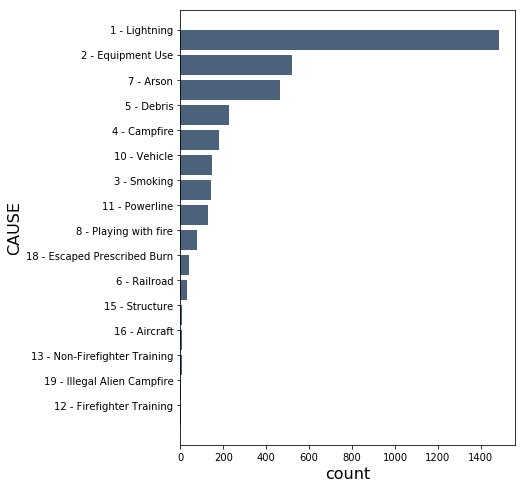

In [40]:
causes16.barh('CAUSE')